In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
from src.nf import NormalizingFlowModel, MAF, CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf, make_clf_dataset
from utils import data_utils

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from scipy.special import logsumexp

from copy import deepcopy

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
! nvidia-smi

Fri Apr 17 20:25:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000666E:00:00.0 Off |                    0 |
| N/A   52C    P0    71W / 149W |  11189MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 0000A3CE:00:00.0 Off |                    0 |
| N/A   69C    P0    95W / 149W |   7868MiB / 11441MiB |     44%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [6]:
data = data_utils.GAS()
dim = data.n_dims
X_train_tensor = torch.from_numpy(data.trn.x).to(device)
X_test_tensor = torch.from_numpy(data.tst.x).to(device)

In [7]:
prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = NormalizingFlowModel(dim, prior, [MAF(dim, 32), MAF(dim, 32), MAF(dim, 32), MAF(dim, 32), MAF(dim, 32)]).to(device)

In [8]:
model.load_state_dict(torch.load('./GAS/modelBig50k'))

<All keys matched successfully>

In [9]:
clf = CatBoostClassifier()
clf.load_model('./GAS/clf_modelBig50k')

In [10]:
calibrated_model = CalibratedModel(clf, model, logit=True)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [11]:
samples = model.sample_n(10000).detach().cpu().numpy()
clf_preds = clf.predict(samples, prediction_type='RawFormulaVal')
calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
calibration_constant

-0.254438529626519

In [12]:
-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model, X_test_tensor) - calibration_constant,

(9.482524871826172, 10.447617559862117)

In [22]:
new_model = deepcopy(model)
optimizer = optim.Adam(new_model.parameters(), lr=0.00005)

In [23]:
epochs = 100
metrics_train = [-neg_log_likelihood(new_model, X_train_tensor)]
metrics_test = [-neg_log_likelihood(new_model, X_test_tensor)]
losses = []
kls = []
rkls = []
batch_size = 100 * 1000

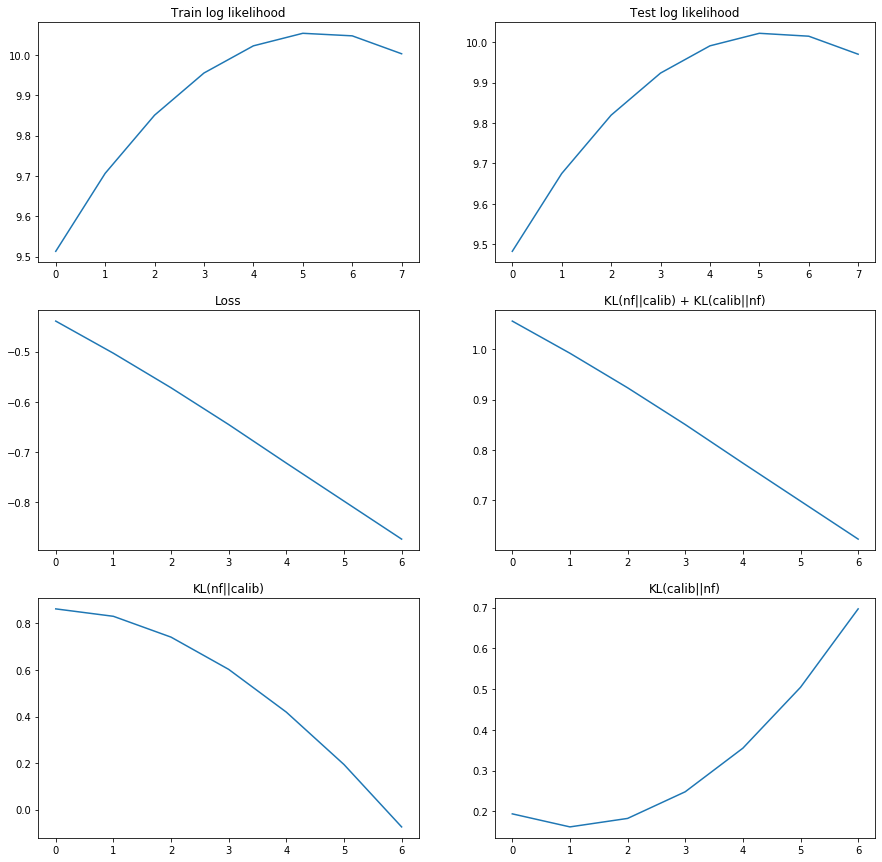

In [24]:
samples_model = new_model.sample_n(500 * 1000).detach()
samples_true = torch.from_numpy(calibrated_model.sample_n(500 * 1000)).to(device)

for i in range(len(losses), epochs):
#     samples_model = new_model.sample_n(batch_size).detach()
#     samples_true = torch.from_numpy(calibrated_model.sample_n(batch_size)).to(device)

    log_probs_model = new_model.log_prob(samples_model)
    log_probs_true = new_model.log_prob(samples_true)
    
    loss = -torch.mean(log_probs_true) + torch.mean(log_probs_model)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    metrics_train.append(-neg_log_likelihood(new_model, X_train_tensor))
    metrics_test.append(-neg_log_likelihood(new_model, X_test_tensor))
    log_probs_model = log_probs_model.detach().cpu().numpy()
    kls.append(np.mean(log_probs_model - calibrated_model.log_prob(samples_model)))
    log_probs_true = log_probs_true.detach().cpu().numpy()
    rkls.append(np.mean(calibrated_model.log_prob(samples_true) - log_probs_true))

    clear_output(False)
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    axs[0, 0].plot(np.arange(0, len(metrics_train)), metrics_train)
    axs[0, 0].set_title('Train log likelihood')
    axs[0, 1].plot(np.arange(0, len(metrics_test)), metrics_test)
    axs[0, 1].set_title('Test log likelihood')
    
    axs[1, 0].plot(np.arange(0, len(losses)), losses)
    axs[1, 0].set_title('Loss')
    
    axs[1, 1].plot(np.arange(0, len(losses)), [x + y for x, y in zip(kls, rkls)])
    axs[1, 1].set_title('KL(nf||calib) + KL(calib||nf)')
    
    axs[2, 0].plot(np.arange(0, len(kls)), kls)
    axs[2, 0].set_title('KL(nf||calib)')
    axs[2, 1].plot(np.arange(0, len(rkls)), rkls)
    axs[2, 1].set_title('KL(calib||nf)')
    plt.show()
    
    if np.mean(log_probs_model - calibrated_model.log_prob(samples_model)) <= 0:
        break

In [30]:
torch.save(new_model.state_dict(), './GAS/modelBig50k_finetuned1')
torch.save(optimizer.state_dict(), './GAS/optimizerBig50k_finetuned1')

In [27]:
clf_ds_train = make_clf_dataset(X_train_tensor, new_model)
clf_ds_test = make_clf_dataset(X_test_tensor, new_model)

new_clf = CatBoostClassifier(
    2000, eval_metric='AUC',
    metric_period=200,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1]),
    use_best_model=False
)

new_calibrated_model = CalibratedModel(new_clf, new_model, logit=True)

Learning rate set to 0.130847
0:	test: 0.5545175	best: 0.5545175 (0)	total: 459ms	remaining: 15m 18s
200:	test: 0.7220501	best: 0.7220501 (200)	total: 38.5s	remaining: 5m 44s
400:	test: 0.7619643	best: 0.7619643 (400)	total: 1m 13s	remaining: 4m 51s
600:	test: 0.7847399	best: 0.7847399 (600)	total: 1m 48s	remaining: 4m 11s
800:	test: 0.8004968	best: 0.8004968 (800)	total: 2m 37s	remaining: 3m 56s
1000:	test: 0.8120013	best: 0.8120013 (1000)	total: 3m 22s	remaining: 3m 22s
1200:	test: 0.8209727	best: 0.8209727 (1200)	total: 4m	remaining: 2m 40s
1400:	test: 0.8285311	best: 0.8285311 (1400)	total: 4m 40s	remaining: 1m 59s
1600:	test: 0.8349823	best: 0.8349823 (1600)	total: 5m 21s	remaining: 1m 20s
1800:	test: 0.8407339	best: 0.8407339 (1800)	total: 5m 59s	remaining: 39.7s
1999:	test: 0.8458652	best: 0.8458652 (1999)	total: 6m 33s	remaining: 0us

bestTest = 0.8458651617
bestIteration = 1999



In [28]:
samples = new_model.sample_n(10000).detach().cpu().numpy()
clf_preds = new_clf.predict(samples, prediction_type='RawFormulaVal')
new_calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
new_calibration_constant

-0.21118240519737164

In [34]:
-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model, X_test_tensor) - calibration_constant, \
-neg_log_likelihood(new_model, X_test_tensor), \
-neg_log_likelihood(new_calibrated_model, X_test_tensor) - new_calibration_constant

(9.482524871826172, 10.447617559862117, 9.970112800598145, 10.811649610391738)